[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)

#### based on Fig. 2 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolBoreal, AerosolMarine, AerosolNascent
from atmos_cloud_sim_uj_utils import show_plot
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.initialisation.spectra import Sum
from PySDM.physics import si
import numpy as np
import matplotlib
from matplotlib import pyplot

In [16]:
consts = {"delta_min":0.1, 
          "MAC":1, 
          "HAC":1, 
          "c_pd":1006 * si.joule / si.kilogram / si.kelvin, 
          "g_std":9.81 * si.metre / si.second ** 2,
          "BDF":False
          }

output = {}
for aerosol in (AerosolMarine(), AerosolBoreal(), AerosolNascent()):
    for model in ('Constant', 'CompressedFilmOvadnevaite'):
        key = f"{aerosol.__class__.__name__}-{model}"
        settings = Settings(
            dz=0.01*si.m, n_sd_per_mode=200, 
            model=model,
            aerosol=aerosol,
            spectral_sampling=spec_sampling.ConstantMultiplicity,
            **consts
        )
        simulation = Simulation(settings)
        output[key] = simulation.run()
        output[key]['color'] = aerosol.color
        output[key]['Na_tot'] = Sum(
            tuple(settings.aerosol.modes[i]['spectrum']
                  for i in range(len(settings.aerosol.modes)))).norm_factor

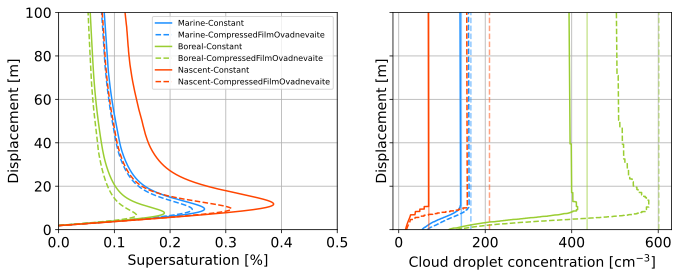

HTML(value="<a href='./fig_2ab.pdf' target='_blank'>./fig_2ab.pdf</a><br>")

In [17]:
figsize = (11, 4)
pyplot.rc('font', size=14)
fig, axs = pyplot.subplots(1, 2, figsize=figsize, sharey=True)

if consts["BDF"]:
    vlist = ('RH', 'n_c_cm3')
else:
    vlist = ('S_max', 'n_c_cm3')

for idx, var in enumerate(vlist):
    for key, out_item in output.items():
        Y = np.asarray(out_item['z'])
        if var == 'RH':
            X = np.asarray(out_item[var]) - 100
        else:
            X = out_item[var]
        axs[idx].plot(X, Y, 
                      label=key.split('Aerosol')[-1], 
                      color=out_item['color'],
                      linestyle='-' if key.endswith('-Constant') else '--'
                     )
        if var == 'n_c_cm3':
            axs[idx].axvline(out_item["Activated Fraction"]*out_item["Na_tot"]*1e-6,
                             color=out_item['color'],
                             alpha=0.5,
                             linestyle='-' if key.endswith('-Constant') else '--'
                            )
    axs[idx].set_ylim(0, 100)
    
    axs[idx].set_ylabel('Displacement [m]')
    if var in ('RH', 'S_max'):
        axs[idx].set_xlabel('Supersaturation [%]')
        axs[idx].set_xlim(0, 0.5)
    elif var == 'n_c_cm3':
        axs[idx].set_xlabel('Cloud droplet concentration [cm$^{-3}$]')
    else:
        assert False
    
for ax in axs:
    ax.grid()
axs[0].legend(fontsize=8)
show_plot("fig_2ab.pdf")

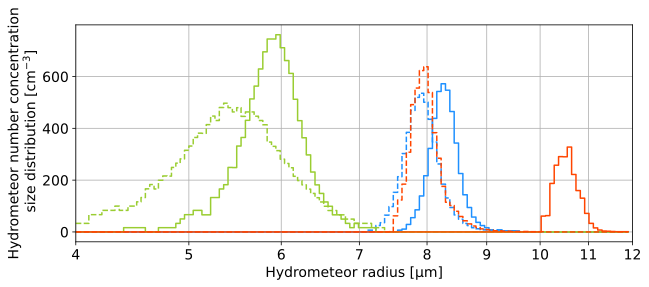

HTML(value="<a href='./fig_2c.pdf' target='_blank'>./fig_2c.pdf</a><br>")

In [18]:
from scipy.ndimage.filters import uniform_filter1d

record_number = -1
figsize = (10, 4)
pyplot.rc('font', size=14)
fig, axs = pyplot.subplots(1, 1, figsize=figsize, sharey=True)

bins = settings.wet_radius_bins_edges / si.um
binwidths = np.diff(bins)
for key, out_item in output.items():
    spectra = out_item['spectrum'] * si.mg * si.um
    pyplot.step(
        bins[:-1],
        uniform_filter1d(spectra * binwidths, size=5),
        label=f'wet ({key})',
        color=out_item['color'],
        linestyle='-' if key.endswith('-Constant') else '--',
        where='pre'
    )
pyplot.xscale('log')
pyplot.grid()
pyplot.xlabel("Hydrometeor radius [μm]")
pyplot.ylabel("Hydrometeor number concentration\n size distribution [cm$^{-3}$]")
xticks = (4,5,6,7,8,9,10,11,12)
axs.set_xticks(xticks)
axs.set_xlim(xticks[0], xticks[-1])
axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
show_plot("fig_2c.pdf")